In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
from torcheval.metrics.functional import binary_f1_score, binary_accuracy
from PIL import Image
from torchvision.transforms import v2 as transforms
import matplotlib.pyplot as plt
import gc

In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

Using device: cuda



In [ ]:
PATH = os.getcwd()
os.chdir(PATH)
train_root_dir = PATH+'/train/images_without_opacity'
test_root_dir = PATH+'/test/images_without_opacity'
save_dir = PATH+"/segmentation_model_1"

os.mkdir(save_dir) if not os.path.exists(save_dir) else None

model_name = save_dir+"/model.pth"
checkpoint_dir = save_dir+"/checkpoint.pth"

CHANNELS=3
SHAPE_DIM = 256
SHAPE = (CHANNELS,SHAPE_DIM,SHAPE_DIM)
BATCH_SIZE = 32
OPTIMIZER = torch.optim.Adam
LEARNING_RATE=0.001
SCHEDULER = torch.optim.lr_scheduler.LambdaLR
LR_LAMBDA = lambda epoch: 0.95**epoch
LOSS_FN = nn.BCEWithLogitsLoss()
EPOCHS = 25 


RANDOM_SEED=42

In [32]:
os.chdir(PATH)

train_image_list = []
train_binary_pred_list = []
train_rle_list = []

if os.path.exists('train'):
    print("train folder exists")
    os.chdir('train')

    with open('train.csv', 'r') as f:
        f.readline()
        lines = f.read().splitlines()
        for i, line in enumerate(lines):
            image_name, binary_pred, train_rle = line.split(',')
            train_image_list.append(image_name)
            train_binary_pred_list.append(int(binary_pred))
            if train_rle == 'Healthy':
                train_rle = None
            train_rle_list.append(train_rle)
else:
    raise FileNotFoundError("train folder does not exist")

train folder exists


In [33]:
len(train_image_list), len(train_binary_pred_list), len(train_rle_list)

(919, 919, 919)

In [11]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [12]:
class PlantDataset(Dataset):
    def __init__(self, root_dir,image_list, binary_pred_list,rle_list, transform=None):
        self.root_dir = root_dir
        self.image_list = image_list
        self.binary_pred_list = binary_pred_list
        self.transform = transform
        self.class_names = ['healthy', 'unhealthy']
        self.classes = [self.class_names[binary_pred] for binary_pred in self.binary_pred_list]
        self.rle_list = rle_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(self.root_dir+'/'+self.image_list[idx])
        binary_pred = self.binary_pred_list[idx]
        
        rle = self.rle_list[idx]
        mask = rle2mask(rle) if rle is not None else np.zeros((256,256))
        mask = torch.from_numpy(mask).type(torch.float32)
        

        if self.transform is not None:
            image = self.transform(image)
            # mask = self.transform(mask)

        return image, binary_pred, mask

(256, 256) RGB
(256, 256) float64
(256, 256) RGB
(256, 256) float64
(256, 256) RGB
(256, 256) uint8
(256, 256) RGB
(256, 256) float64
(256, 256) RGB
(256, 256) float64


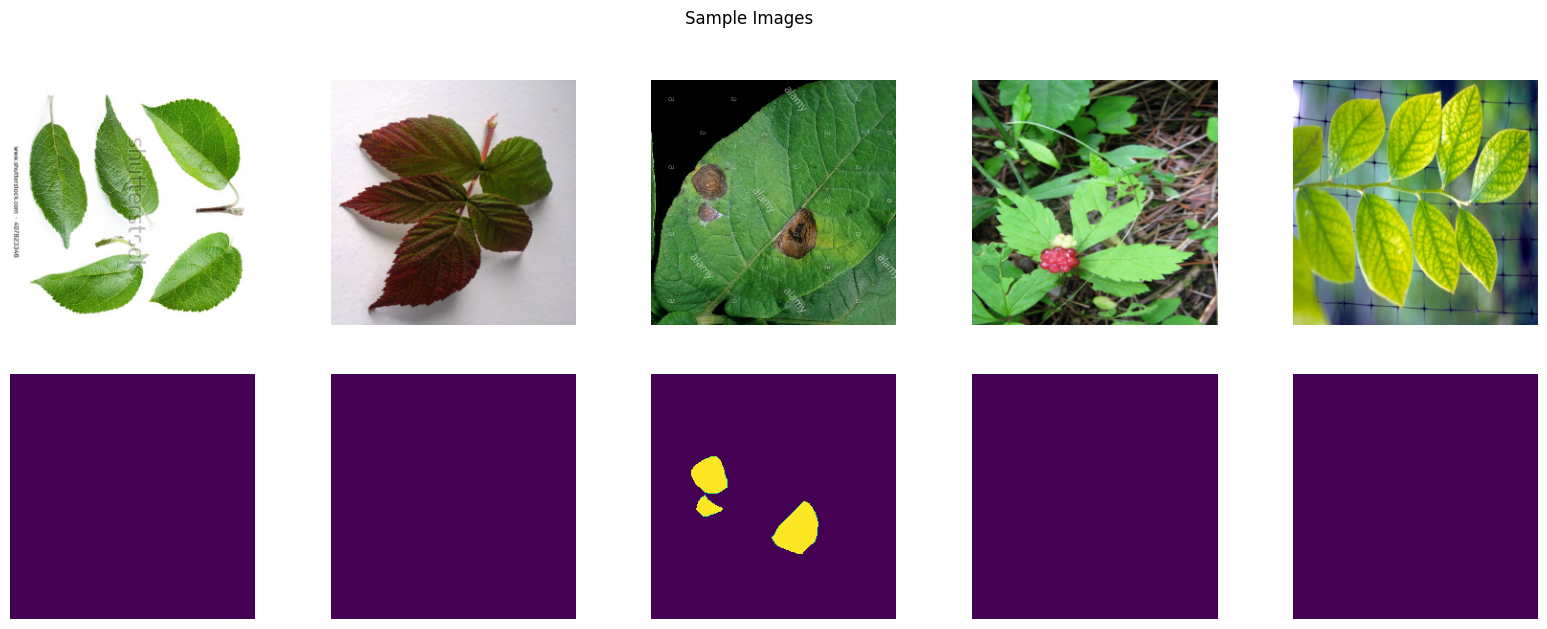

In [36]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,5,figsize=(20,7))
fig.suptitle('Sample Images')

list = np.random.randint(0, len(train_image_list), 5)


for i,idx in enumerate(list):
    image = Image.open(train_root_dir+'/'+train_image_list[idx])
    rle = train_rle_list[idx]
    mask = rle2mask(rle) if rle is not None else np.zeros((256,256))

    print(image.size, image.mode)
    print(mask.shape, mask.dtype)

    ax[0,i].imshow(image)
    ax[0,i].axis('off')
    ax[1,i].imshow(mask)
    ax[1,i].axis('off')

In [37]:
from torchvision.transforms import v2 as transforms

transform = transforms.Compose([
    transforms.Resize(SHAPE_DIM),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [38]:
from torch.utils.data import DataLoader, random_split

dataset = PlantDataset(train_root_dir, train_image_list, train_binary_pred_list, train_rle_list, transform=transform)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(735, 184)

In [40]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)

(23, 6)

In [41]:
# save train_loader and val_loader
if not os.path.exists(save_dir+"/train_loader.pth"):
    torch.save(train_loader, save_dir+"/train_loader.pth")
if not os.path.exists(save_dir+"/val_loader.pth"):
    torch.save(val_loader, save_dir+"/val_loader.pth")

In [4]:
from UNet import UNet

In [43]:
# insantiate the model
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = UNet(in_channels=CHANNELS).to(device)
optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE)
scheduler = SCHEDULER(optimizer, lr_lambda=LR_LAMBDA)
loss_fn = LOSS_FN
epochs = EPOCHS
start_epoch = 0 

In [44]:
if os.path.exists(checkpoint_dir):
    checkpoint = torch.load(checkpoint_dir)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    print(f"Loaded checkpoint from epoch {start_epoch} with loss {loss}")
    train_loader = torch.load(save_dir+"/train_loader.pth")
    val_loader = torch.load(save_dir+"/val_loader.pth")

Loaded checkpoint from epoch 18 with loss 0.17265300452709198


In [45]:
# Dice Score:
# Takes in two tensors and computes the dice score
# Tensor should be of shape (N, H, W) where N is the batch size
def dice_score(predicition_mask, ground_truth_mask):
    smooth = 1e-6
    intersection = torch.sum(predicition_mask * ground_truth_mask)
    union = torch.sum(predicition_mask) + torch.sum(ground_truth_mask)
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

def accuracy(groundtruth_mask, pred_mask):
    # Ensure the tensors are on the same device
    groundtruth_mask = groundtruth_mask.to(pred_mask.device)

    # Flatten the tensors. The shape of the tensors is (N, H, W)
    groundtruth_mask = groundtruth_mask.view(groundtruth_mask.shape[0], -1)
    pred_mask = pred_mask.view(pred_mask.shape[0], -1)

    # Calculate the intersection and union
    intersect = torch.sum(pred_mask * groundtruth_mask, dim=1)
    union = torch.sum(pred_mask, dim=1) + torch.sum(groundtruth_mask, dim=1) - intersect

    # Calculate XOR
    xor = torch.sum(pred_mask == groundtruth_mask, dim=1)

    # Calculate accuracy
    acc = (xor / (union + xor - intersect)).mean()

    return acc

In [46]:
if device == 'cuda':
    torch.cuda.empty_cache()

print("Testing Forward Pass")
image, binary_pred, mask = next(iter(train_loader))
image = image.to(device)
mask = mask.to(device)

with torch.inference_mode():
    output = model(image)
    binary_mask_test = nn.Sigmoid()(output)

print(f"IMAGE - {image.shape},BINARY_PRED - {binary_pred.shape}, MASK - {mask.shape}, OUTPUT - {output.shape}, BINARY_MASK_PRED - {binary_mask_test.shape}")
print(f"Loss Function of BCEWithLogitsLoss = {LOSS_FN(output, mask)}")
print(f"Dice Metric = {dice_score(binary_mask_test, mask)}")

Testing Forward Pass
IMAGE - torch.Size([32, 3, 256, 256]),BINARY_PRED - torch.Size([32]), MASK - torch.Size([32, 256, 256]), OUTPUT - torch.Size([32, 256, 256]), BINARY_MASK_PRED - torch.Size([32, 256, 256])
Loss Function of BCEWithLogitsLoss = 0.24224445223808289
Dice Metric = 0.24416249990463257


In [47]:
random_idx = np.random.randint(0, BATCH_SIZE,size=5)
# fig,axis = plt.subplots(3,5,figsize=(20,10))
# fig.suptitle('Sample Images')

for i,idx in enumerate(random_idx):
    image, binary_pred, mask = train_dataset[idx]
    image = image.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
        binary_mask_test = nn.Sigmoid()(output)

    image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
    mask = mask.squeeze().cpu().numpy()
    binary_mask_test = binary_mask_test.squeeze().cpu().detach().numpy()

    # axis[0,i].imshow(image)
    # axis[0,i].axis('off')
    # axis[1,i].imshow(mask, cmap='gray')
    # axis[1,i].axis('off')
    # axis[2,i].imshow(binary_mask_test, cmap='gray')
    # axis[2,i].axis('off')

# deleting these test variables
del image, binary_pred, mask, output, binary_mask_test
gc.collect()

33893

In [48]:
from tqdm.notebook import tqdm

if device == 'cuda':
    torch.cuda.empty_cache()
    
os.mkdir(save_dir) if not os.path.exists(save_dir) else None

epoch_count = []
train_loss_list = []
train_acc_list = []
train_dice_list = []
val_loss_list = []
val_acc_list = []
val_dice_list = []

for epoch in tqdm(range(start_epoch,epochs)):

    if epoch == 0:
        with open(save_dir+"/training_results.txt",'w') as f:
            f.write("Epoch,Train Loss,Train Accuracy,Train Dice Score,Val Loss,Val Accuracy,Val Dice Score\n")

    if epoch == start_epoch:
        with open(save_dir+"/training_results.txt",'a') as f:
            f.write('\n')
    
    print(f"\nEpoch: {epoch + 1}\n")
    train_loss = 0.0
    train_acc = 0.0
    train_dice = 0.0
    val_loss = 0.0
    val_acc = 0.0
    val_dice = 0.0

    for batch, (X,Y,mask) in enumerate(train_loader):

        if batch % 4 == 0:
            print(f"Epoch: {epoch+1}/{EPOCHS} Batch: {batch}/{len(train_loader)}")

        model.train()
        X = X.to(device)
        Y = Y.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        output = model(X)
        binary_mask_pred = nn.Sigmoid()(output)
        loss = loss_fn(output, mask)
        train_loss+= loss.item()
        train_acc+= binary_accuracy(binary_mask_pred.flatten(), mask.flatten()).item()
        train_dice+= dice_score(binary_mask_pred, mask).item()
        loss.backward()
        optimizer.step()
        
        del output, binary_mask_pred
        gc.collect()
    
    if scheduler is not None:
        scheduler.step()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_dice /= len(train_loader)

    model.eval()
    with torch.inference_mode():
        for X,Y,mask in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            mask = mask.to(device)

            output = model(X)
            binary_mask_pred = nn.Sigmoid()(output)
            loss = LOSS_FN(output, mask)
            val_loss += loss.item()
            val_acc += binary_accuracy(binary_mask_pred.flatten(), mask.flatten()).item()
            val_dice += dice_score(binary_mask_pred, mask).item()
            del output, binary_mask_pred
            gc.collect()
        
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_dice /= len(val_loader)

    if device == 'cuda':
        torch.cuda.empty_cache()

    print(f"\nEpoch: {epoch+1}/{EPOCHS} | Train Loss: {train_loss} | Train Accuracy: {train_acc} | Train Dice Score: {train_dice} | Val Loss: {val_loss } | Val Accuracy: {val_acc} | Val Dice Score: {val_dice}")

    # save checkpoint:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_dir)

    with open(save_dir+"/training_results.txt",'a') as f:
        f.write(f"{epoch+1}, {train_loss}, {train_acc}, {train_dice}, {val_loss}, {val_acc}, {val_dice}\n")

    epoch_count.append(epoch)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    train_dice_list.append(train_dice)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    val_dice_list.append(val_dice)

torch.save(model.state_dict(),model_name)




  0%|          | 0/7 [00:00<?, ?it/s]


Epoch: 19

Epoch: 19/25 Batch: 0/23
Epoch: 19/25 Batch: 4/23
Epoch: 19/25 Batch: 8/23
Epoch: 19/25 Batch: 12/23
Epoch: 19/25 Batch: 16/23
Epoch: 19/25 Batch: 20/23

Epoch: 19/25 | Train Loss: 0.21383177132710166 | Train Accuracy: 0.9215794879457225 | Train Dice Score: 0.1989333292712336 | Val Loss: 0.19850739339987436 | Val Accuracy: 0.9255022505919138 | Val Dice Score: 0.20368604362010956

Epoch: 20

Epoch: 20/25 Batch: 0/23
Epoch: 20/25 Batch: 4/23
Epoch: 20/25 Batch: 8/23
Epoch: 20/25 Batch: 12/23
Epoch: 20/25 Batch: 16/23
Epoch: 20/25 Batch: 20/23

Epoch: 20/25 | Train Loss: 0.21478595422661823 | Train Accuracy: 0.9215539693832397 | Train Dice Score: 0.20520429896271747 | Val Loss: 0.19988527645667395 | Val Accuracy: 0.9255022505919138 | Val Dice Score: 0.21387467284997305

Epoch: 21

Epoch: 21/25 Batch: 0/23
Epoch: 21/25 Batch: 4/23
Epoch: 21/25 Batch: 8/23
Epoch: 21/25 Batch: 12/23
Epoch: 21/25 Batch: 16/23
Epoch: 21/25 Batch: 20/23

Epoch: 21/25 | Train Loss: 0.2146740763083748

In [49]:
import torch
torch.save(model.state_dict(),save_dir+"model_epoch_18.pth")
checkpoint_18 = checkpoint
torch.save(checkpoint, save_dir+"checkpoint_epoch_18.pth")


[ 5 17 18 16 18]


76853

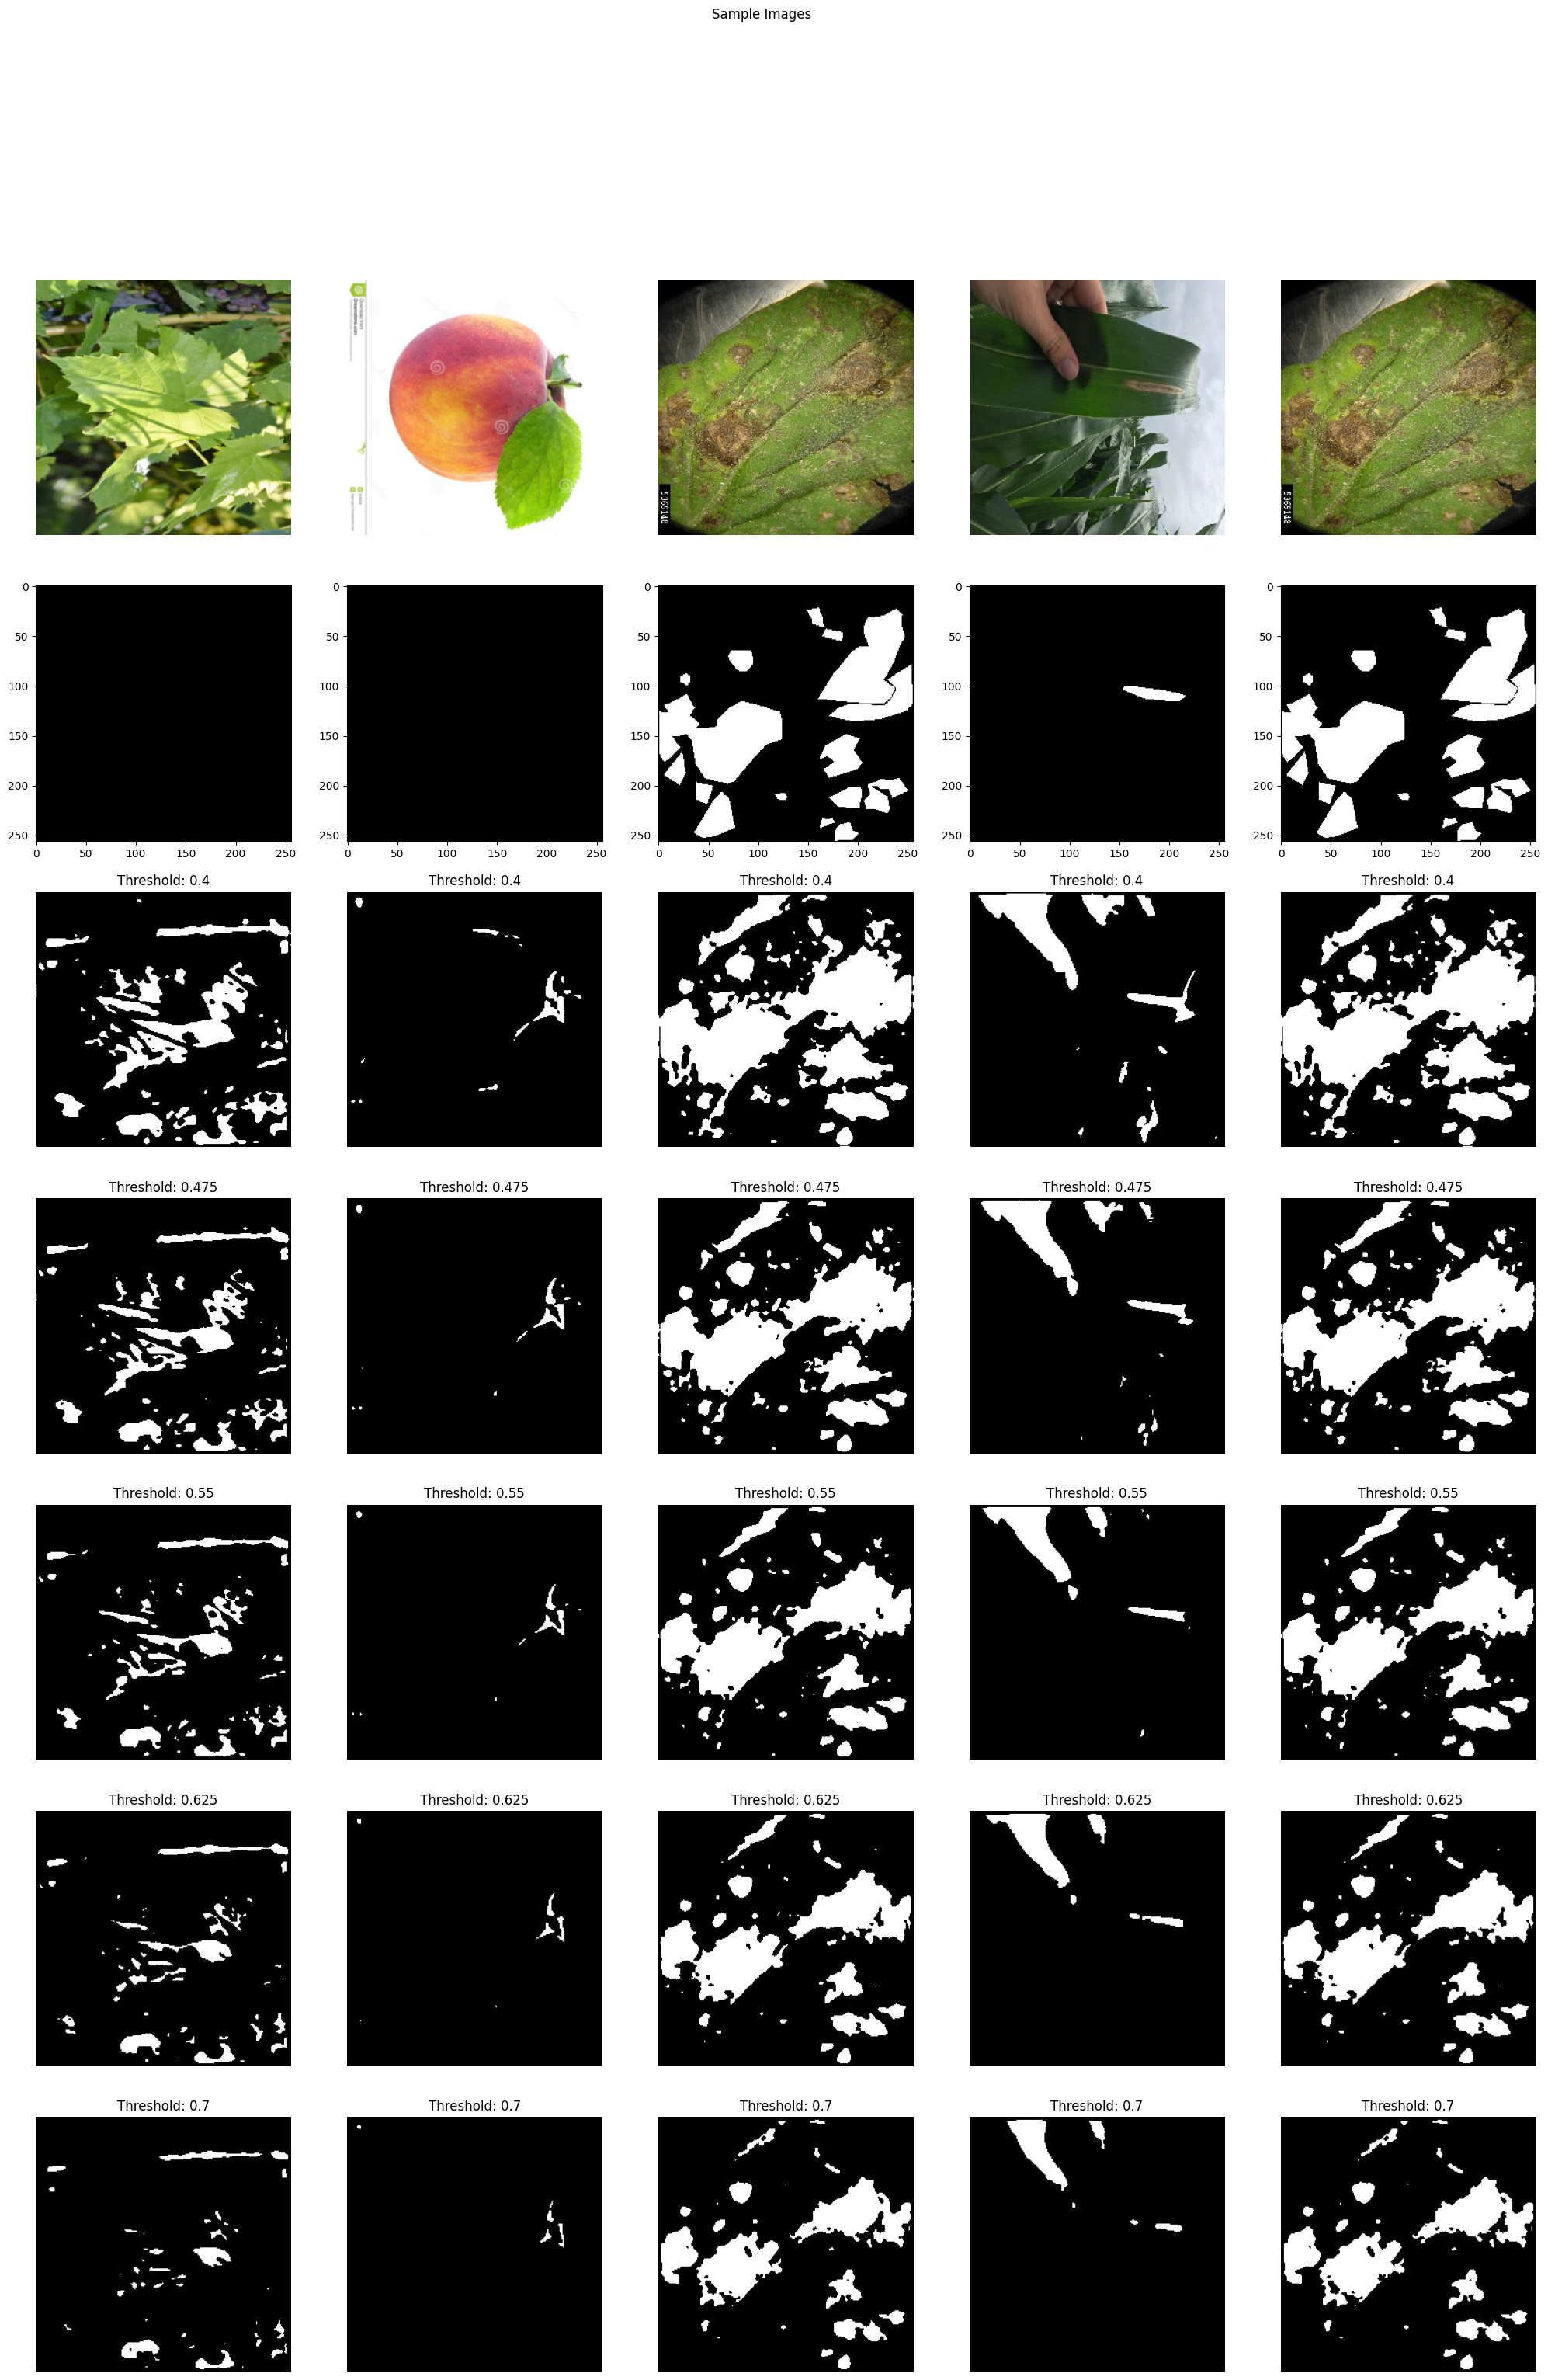

In [53]:
# np.random.seed(RANDOM_SEED-2)
random_idx = np.random.randint(0, BATCH_SIZE,size=5,)
fig,axis = plt.subplots(7,5,figsize=(25,35))
fig.suptitle('Sample Images')
print(random_idx)

for i,idx in enumerate(random_idx):
    # image, binary_pred, mask = train_dataset[idx]
    image, binary_pred, mask = val_dataset[idx]
    image = image.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
        binary_mask_test = nn.Sigmoid()(output)

    image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
    mask = mask.squeeze().cpu().numpy()
    
    binary_mask_test = binary_mask_test.squeeze().cpu().detach().numpy()

    # normalise binary_mask_test between 0,1
    binary_mask_test = (binary_mask_test - binary_mask_test.min())/(binary_mask_test.max()-binary_mask_test.min())

    # binary_mask_pred = np.round(binary_mask_test)

    threshold = np.linspace(0.4,0.7,5)
    

    axis[0,i].imshow(image)
    axis[0,i].axis('off')
    axis[1,i].imshow(mask, cmap='gray')

    for j in range(5):
        # binary_mask_pred_ = binary_mask_pred[j]
        # axis[1,i].axis('off')
        # axis[2,i].imshow(binary_mask_pred, cmap='gray')
        # axis[2,i].axis('off')
        binary_mask_pred = (binary_mask_test > threshold[j]).astype(np.uint8)
        axis[j+2,i].imshow(binary_mask_pred, cmap='gray')
        axis[j+2,i].axis('off')
        axis[j+2,i].set_title(f"Threshold: {threshold[j]}")

# deleting these test variables
del image, binary_pred, mask, output, binary_mask_test
gc.collect()

In [51]:
import pandas as pd

training_results_df = pd.read_csv(save_dir+'/training_results.txt')
training_results_df


,Epoch,Train Loss,Train Accuracy,Train Dice Score,Val Loss,Val Accuracy,Val Dice Score
0,1,0.388162,0.921579,0.090217,0.246045,0.925502,0.112534
1,2,0.245115,0.921554,0.122288,0.221296,0.925502,0.150837
2,3,0.231901,0.921626,0.153911,0.214232,0.925502,0.177492
3,4,0.228206,0.921562,0.170767,0.209308,0.925502,0.181324
4,5,0.222156,0.921609,0.182425,0.206124,0.925502,0.191307
5,6,0.220503,0.921579,0.181658,0.203872,0.925502,0.197390
6,7,0.225005,0.921554,0.191195,0.203026,0.925502,0.201947
7,8,0.219575,0.921626,0.197041,0.208995,0.925502,0.211037
8,9,0.222374,0.921562,0.186137,0.201978,0.925502,0.195384
9,10,0.228108,0.912313,0.196316,0.203281,0.925502,0.201797


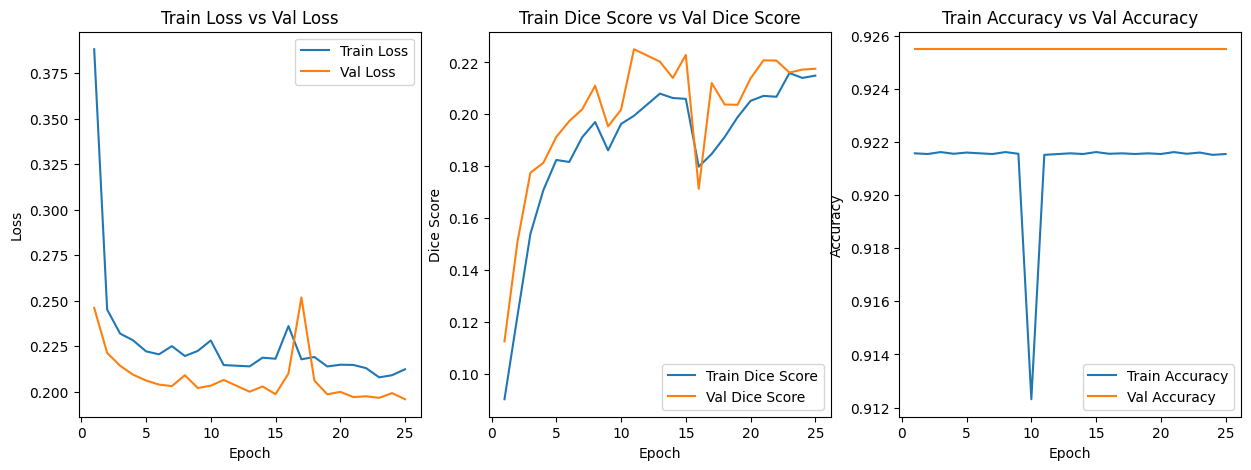

In [52]:
plt.figure(figsize=(15, 5))

# Plot Train Loss and Val Loss
plt.subplot(1,3,1)
plt.plot(training_results_df["Epoch"], training_results_df["Train Loss"], label='Train Loss')
plt.plot(training_results_df["Epoch"], training_results_df["Val Loss"], label='Val Loss')
plt.title('Train Loss vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Train Dice Score and Val Dice Score
plt.subplot(1,3,2)
plt.plot(training_results_df["Epoch"], training_results_df["Train Dice Score"], label='Train Dice Score')
plt.plot(training_results_df["Epoch"], training_results_df["Val Dice Score"], label='Val Dice Score')
plt.title('Train Dice Score vs Val Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Plot Train Accuracy and Val Accuracy
plt.subplot(1,3,3)
plt.plot(training_results_df["Epoch"], training_results_df["Train Accuracy"], label='Train Accuracy')
plt.plot(training_results_df["Epoch"], training_results_df["Val Accuracy"], label='Val Accuracy')
plt.title('Train Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [7]:
model = UNet(in_channels=CHANNELS).to(device)
model.load_state_dict(torch.load(model_name))

d:\Program Files\Python\Lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)


<All keys matched successfully>

In [8]:
os.chdir(PATH)

test_image_list = []
test_binary_pred_list = []

if os.path.exists('test'):
    print("test folder exists")
    os.chdir('test')

    with open('test.csv', 'r') as f:
        f.readline()
        lines = f.read().splitlines()
        for i, line in enumerate(lines):
                        image_name, binary_pred, temp = line.split(',')
                        test_image_list.append(image_name)
                        test_binary_pred_list.append(binary_pred)
else:
    raise FileNotFoundError("test folder does not exist")

os.chdir(PATH)

test folder exists


In [9]:
test_binary_pred_list=[0]*len(test_binary_pred_list)

In [13]:
# get mask for each image in test_image_list

test_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

test_dataset = PlantDataset(test_root_dir, test_image_list, test_binary_pred_list, [None]*len(test_image_list), transform=test_transform)

In [64]:
test_mask_pred=[]
threshold = 0.55
for i in range(len(test_image_list)):
    image = test_dataset[i][0].unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
        binary_mask_test = nn.Sigmoid()(output)
        binary_mask_test = binary_mask_test.squeeze().cpu().detach().numpy()
        binary_mask_test = (binary_mask_test - binary_mask_test.min())/(binary_mask_test.max()-binary_mask_test.min())
        binary_mask_pred = (binary_mask_test > threshold).astype(np.uint8)

        # extend mask to 3 channels by copying it two 2 times
        # binary_mask_pred = np.stack([binary_mask_pred]*3, axis=-1)

        test_mask_pred.append(binary_mask_pred)

test_mask_pred = np.array(test_mask_pred)
test_mask_pred.shape

(394, 256, 256)

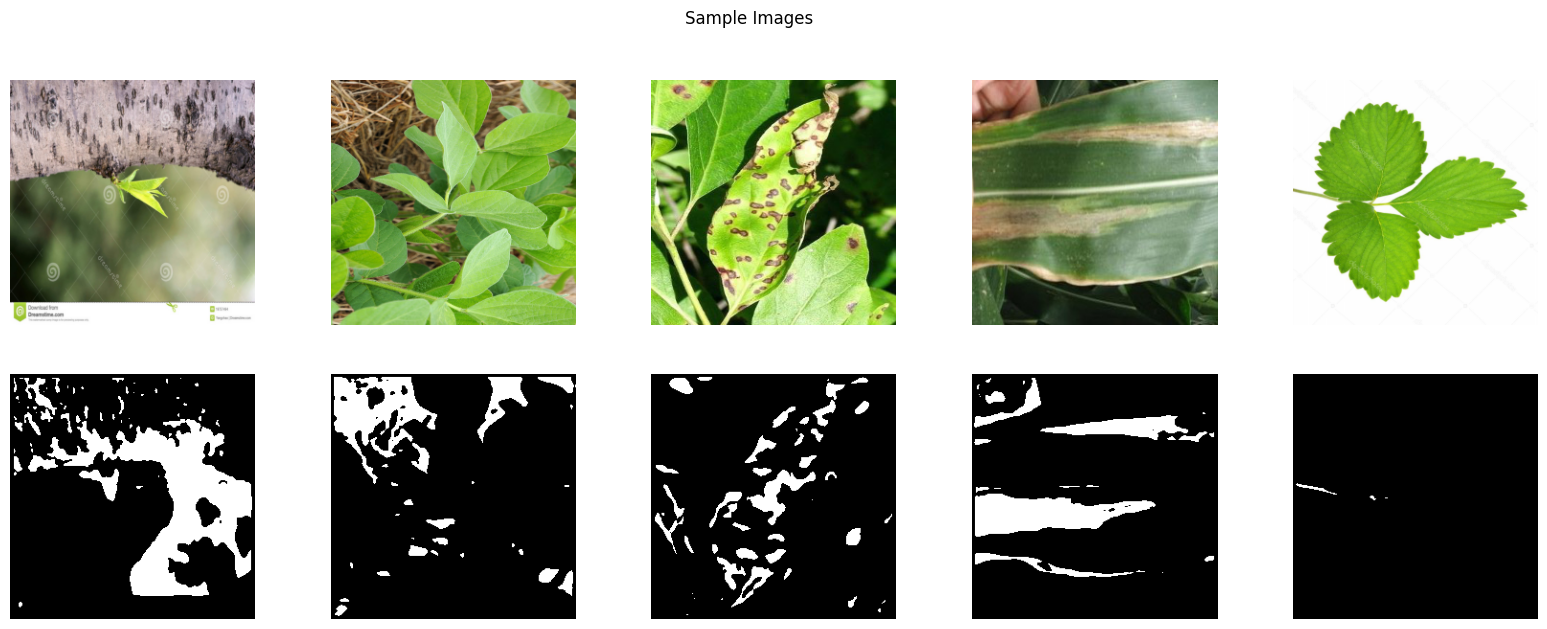

In [65]:
random_idx = np.random.randint(0, len(test_image_list),size=5)
fig,axis = plt.subplots(2,5,figsize=(20,7))
fig.suptitle('Sample Images')

for i,idx in enumerate(random_idx):
    image = Image.open(test_root_dir+'/'+test_image_list[idx])
    mask = test_mask_pred[idx]

    axis[0,i].imshow(image)
    axis[0,i].axis('off')
    axis[1,i].imshow(mask, cmap='gray')
    axis[1,i].axis('off')

In [66]:
test_rle_pred = [mask2rle(mask) for mask in test_mask_pred]
test_rle_pred = np.array(test_rle_pred)
test_rle_pred.shape

(394,)

In [68]:
submitfile=pd.read_csv(save_dir+'/sample_submission.csv')
submitfile.head()

,id,binary_pred,segmentation_pred
0,Img_919.png,0,Healthy
1,Img_920.png,0,Healthy
2,Img_921.png,0,Healthy
3,Img_922.png,0,Healthy
4,Img_923.png,0,Healthy


In [69]:
submitfile['segmentation_pred']=test_rle_pred
submitfile.head()

,id,binary_pred,segmentation_pred
0,Img_919.png,0,773 4 781 2 792 4 918 3 984 27 1016 5 1028 15 ...
1,Img_920.png,0,749 4 927 1 981 30 1127 2 1181 5 1227 2 1236 3...
2,Img_921.png,0,2313 4 2569 5 2825 4 13454 8 13710 14 13966 16...
3,Img_922.png,0,16189 4 16442 8 16696 10 16953 10 17209 10 174...
4,Img_923.png,0,22121 1 22372 6 22625 8 22879 9 23135 8 23391 ...


In [70]:
# save as csv 
submitfile.to_csv(save_dir+"/segmentation_pred_t_55.csv", index=False)
